<a href="https://colab.research.google.com/github/Raanank10/Detecting-Parkinson-s-Disease/blob/080821/Detecting_Parkinsons_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Parkinsons Disease

In [629]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier


# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version
import re

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [630]:
url = 'https://raw.githubusercontent.com/Raanank10/Detecting-Parkinson-s-Disease/main/parkinsons.csv'

data = pd.read_csv(url)
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [631]:
trainSize = 0.80
randState = 990

# EDA

In [632]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

## Data Cleaning

In [633]:
data.nunique()

name                195
MDVP:Fo(Hz)         195
MDVP:Fhi(Hz)        195
MDVP:Flo(Hz)        195
MDVP:Jitter(%)      173
MDVP:Jitter(Abs)     19
MDVP:RAP            155
MDVP:PPQ            165
Jitter:DDP          180
MDVP:Shimmer        188
MDVP:Shimmer(dB)    149
Shimmer:APQ3        184
Shimmer:APQ5        189
MDVP:APQ            189
Shimmer:DDA         189
NHR                 185
HNR                 195
status                2
RPDE                195
DFA                 195
spread1             195
spread2             194
D2                  195
PPE                 195
dtype: int64

In [634]:
unique_data = data.drop_duplicates(inplace=False)
unique_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [635]:
data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [636]:
#DataFlair - Get the features and labels
features = data.loc[:,data.columns!='status'].values[:,1:]
labels = data.loc[:,'status'].values

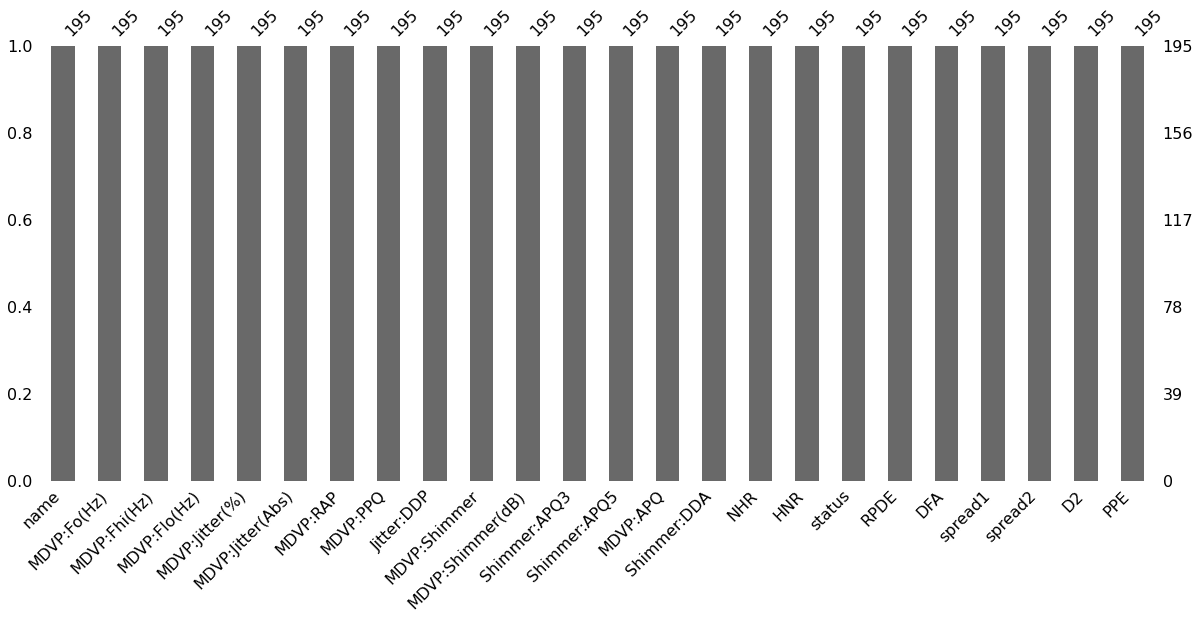

In [637]:
msno.bar(data, figsize=(20, 8))

## Preprocessing

In [638]:
data.corr()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,-0.094717,-0.070682,-0.077774,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,-0.003743,-0.009997,0.004937,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,-0.150747,-0.101095,-0.107293,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,0.746625,0.725561,0.758255,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,0.697153,0.648961,0.648793,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,0.744912,0.709927,0.737455,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,0.763580,0.786780,0.804139,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,0.744894,0.709907,0.737439,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,0.987625,0.982835,0.950083,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,0.963198,0.973751,0.960977,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


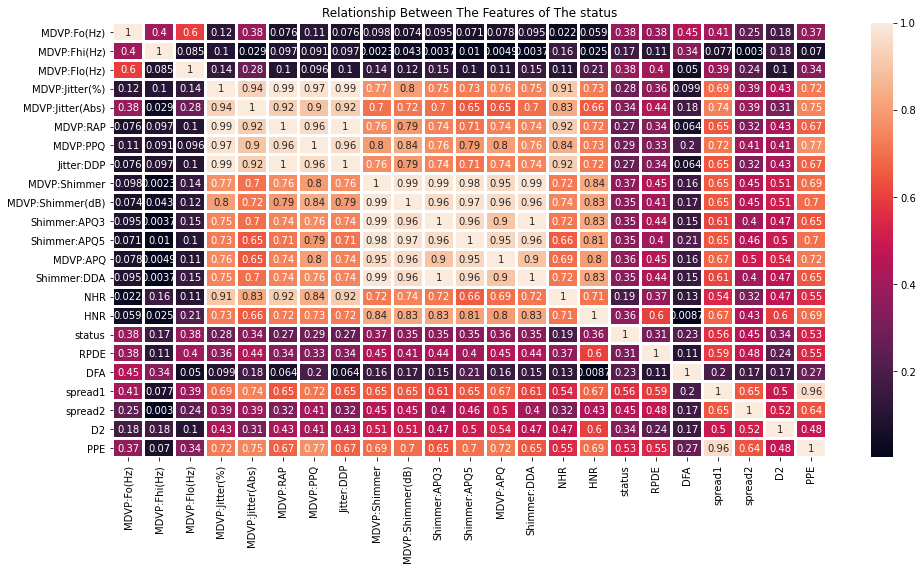

In [639]:
plt.figure(figsize=(16,8))
plt.title("Relationship Between The Features of The status")
sns.heatmap(data.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [640]:
fig = px.histogram(data, x='spread1', title='Distribution of spread1', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [641]:
fig = px.histogram(data, x='spread2', title='Distribution of spread2', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [642]:
fig = px.histogram(data, x='PPE', title='Distribution of PPE', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [643]:
data.status.value_counts()

1    147
0     48
Name: status, dtype: int64

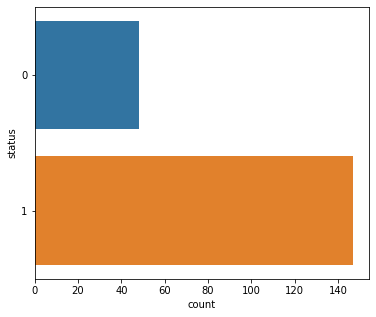

In [644]:
fig , ax = plt.subplots(figsize = (6,5))
ax = sns.countplot(y= 'status', data = data)

In [645]:
# MinMaxScaler
scaler= MinMaxScaler((-1,1))
x=scaler.fit_transform(features)
y=labels

In [646]:
enc = OrdinalEncoder()

In [647]:
enc.fit(unique_data[['name']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [648]:
data['name_as_number'] = enc.transform(data[['name']])
data = data.drop('name', axis=1)

# Spliting the Data

In [649]:
X = data.drop('status', axis=1)
y = data.status

X_train,X_test,y_train,y_test=train_test_split(X, y, train_size = trainSize, \
      random_state = randState, stratify = data.status)

In [650]:
print('train_df shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('X_train shape :',y_train.shape)
print('test_df shape :',y_test.shape)

train_df shape : (156, 23)
X_test shape : (39, 23)
X_train shape : (156,)
test_df shape : (39,)


# Different predictions models

# Model 1 Decision Tree unbalanced Data

In [651]:
t1 = time()
dt_model_1 = DecisionTreeClassifier().fit(X_train, y_train)
t2 = time()
print(f"DecisionTree unbalanced took {t2-t1:.2f} seconds")

DecisionTree unbalanced took 0.00 seconds


In [652]:
def visualize_tree(model, md=10, width=800):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md, label='none')
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=width) 

In [653]:
def print_dot_text(model, md=5):
    """The output of this function can be copied to http://www.webgraphviz.com/"""
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    dot_text = dot_data.getvalue()
    print(dot_text)

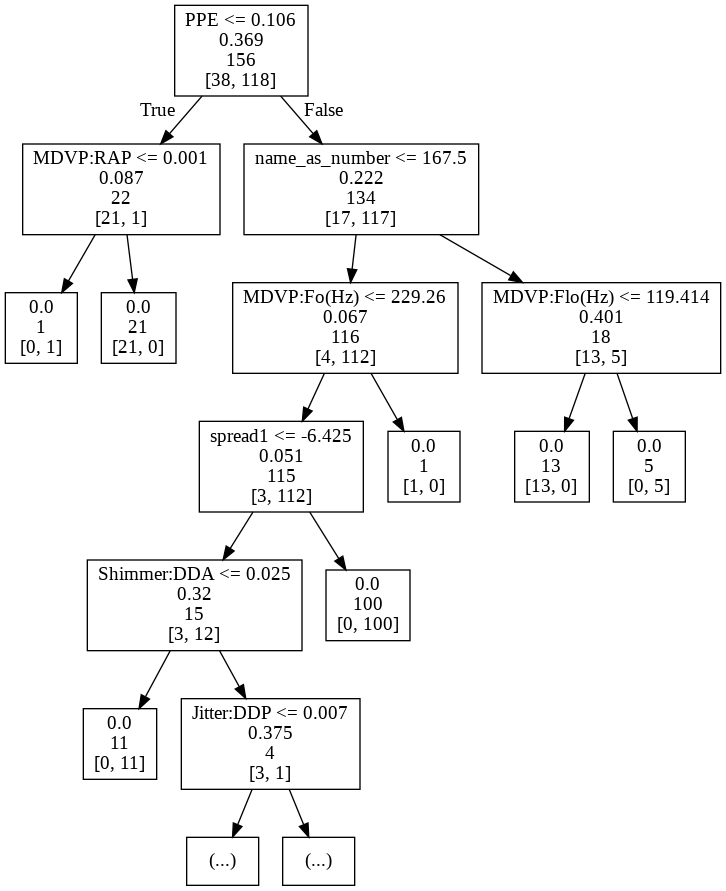

In [654]:
visualize_tree(dt_model_1, md=5, width=600)

In [655]:
pd.Series(dt_model_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

PPE                 0.450388
name_as_number      0.256409
MDVP:Flo(Hz)        0.125632
Shimmer:DDA         0.057404
MDVP:RAP            0.033209
MDVP:Fo(Hz)         0.032714
Jitter:DDP          0.026093
spread1             0.018151
RPDE                0.000000
MDVP:Fhi(Hz)        0.000000
D2                  0.000000
MDVP:Jitter(%)      0.000000
MDVP:Jitter(Abs)    0.000000
spread2             0.000000
MDVP:PPQ            0.000000
MDVP:Shimmer        0.000000
HNR                 0.000000
MDVP:Shimmer(dB)    0.000000
Shimmer:APQ3        0.000000
MDVP:APQ            0.000000
DFA                 0.000000
NHR                 0.000000
Shimmer:APQ5        0.000000
dtype: float64

In [656]:
dt_model_1.tree_.max_depth

6

In [657]:
dt_model_1.feature_importances_

array([0.03271442, 0.        , 0.12563188, 0.        , 0.        ,
       0.03320899, 0.        , 0.02609277, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0574041 , 0.        ,
       0.        , 0.        , 0.        , 0.0181515 , 0.        ,
       0.        , 0.45038775, 0.2564086 ])

### Evaluate the model

In [658]:
X_test_pred = X_test.copy()

X_test_pred['y_pred'] = dt_model_1.predict(X_test)
X_test_pred['y_train'] = y_test
X_test_pred.sample(6)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,y_pred,y_train
183,117.226,123.925,106.656,0.00417,0.00004,0.00186,0.00270,0.00558,0.01909,0.171,0.00864,0.01223,0.01949,0.02592,0.00955,23.079,0.603515,0.669565,-5.619070,0.191576,2.027228,0.215724,183.0,0,0
122,138.190,203.522,83.340,0.00704,0.00005,0.00406,0.00398,0.01218,0.04479,0.441,0.02587,0.02567,0.03220,0.07761,0.01968,18.305,0.538016,0.741480,-5.418787,0.160267,2.090438,0.229892,122.0,1,1
73,112.014,588.518,107.024,0.00533,0.00005,0.00268,0.00329,0.00805,0.02448,0.226,0.01373,0.01375,0.01956,0.04120,0.00623,24.178,0.509127,0.789532,-5.389129,0.306636,1.928708,0.225461,73.0,1,1
31,199.228,209.512,192.091,0.00241,0.00001,0.00134,0.00138,0.00402,0.01015,0.089,0.00504,0.00641,0.00762,0.01513,0.00167,30.940,0.432439,0.742055,-7.682587,0.173319,2.103106,0.068501,31.0,0,0
137,113.166,130.270,100.673,0.00502,0.00004,0.00257,0.00312,0.00772,0.05279,0.476,0.02896,0.03347,0.04134,0.08689,0.03690,16.747,0.625362,0.708617,-4.654894,0.304107,2.672362,0.274387,137.0,1,1
173,113.715,116.443,96.913,0.00349,0.00003,0.00171,0.00203,0.00514,0.01472,0.133,0.00748,0.00905,0.01148,0.02245,0.00478,26.547,0.380253,0.766700,-5.943501,0.192150,1.852542,0.179677,173.0,0,0


In [659]:
X_test_pred['que'] = np.where((X_test_pred['y_pred'] == X_test_pred['y_train'])\
                     , 'yes', 'no')
X_test_pred['que'].value_counts()

yes    38
no      1
Name: que, dtype: int64

In [660]:
preds_1= dt_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_1)

0.9827586206896552

In [661]:
log_loss(y_test, preds_1)

0.8856096511515568

In [662]:
accuracy_score(y_true=y_test, y_pred= preds_1)

0.9743589743589743

Text(0.5, 15.0, 'Predicted label')

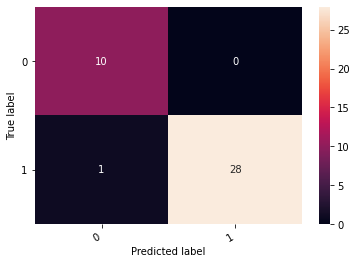

In [663]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [664]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred.y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.97      0.98        29

    accuracy                           0.97        39
   macro avg       0.95      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



In [665]:
my_cv = StratifiedShuffleSplit(n_splits = 26, train_size = 0.75, random_state = randState) 

In [666]:
-cross_val_score(dt_model_1, X_train, y_train, cv=my_cv, scoring='accuracy') 

array([-0.97435897, -0.8974359 , -0.92307692, -0.82051282, -1.        ,
       -0.97435897, -0.76923077, -0.8974359 , -1.        , -0.97435897,
       -0.79487179, -0.94871795, -0.94871795, -0.87179487, -0.97435897,
       -0.94871795, -0.94871795, -0.84615385, -0.94871795, -0.8974359 ,
       -0.92307692, -0.92307692, -0.8974359 , -0.94871795, -0.94871795,
       -0.8974359 ])

In [667]:
dt_model_1_gs = DecisionTreeClassifier(min_samples_leaf=40, min_weight_fraction_leaf=0.01)

In [668]:
# %%timeit
-cross_val_score(dt_model_1_gs, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.42996605, 0.57133617, 0.40475617, 0.64397605, 0.29684353,
       0.39508587, 0.50502923, 0.47900036, 0.57133617, 0.35242776,
       0.48248536, 0.43597096, 0.34887558, 0.34883355, 0.31528888,
       0.30884943, 0.51195759, 0.41218934, 0.53122101, 0.63718731,
       0.36338501, 0.45109621, 0.40877909, 0.38400476, 0.33540792,
       0.37378547])

In [669]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [670]:
dt_model_gs = GridSearchCV(estimator=dt_model_1_gs, param_grid=my_param_grid,\
                           cv=my_cv, scoring='neg_log_loss')

In [671]:
# %%timeit
dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min_weigh...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='

In [672]:
print("Best parameters:", dt_model_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-06, 'min_samples_leaf': 40, 'min_weight_fraction_leaf': 0.02}


In [673]:
dt_model_gs_2 = dt_model_gs.best_estimator_

In [674]:
y_test_pred_gs_2 = pd.DataFrame(dt_model_gs_2.predict_proba(X_test),\
                           columns=dt_model_gs_2.classes_)

In [675]:
log_loss(y_true=y_test, y_pred=y_test_pred_gs_2)

1.2536614562802415

In [676]:
X_test_pred_2 = X_test.copy()

X_test_pred_2['y_pred'] = dt_model_gs_2.predict(X_test)
X_test_pred_2['y_train'] = y_test
X_test_pred_2.sample(6)

roc_auc_score(y_test,preds_gs_2)

0.7137931034482758

In [677]:
log_loss(y_test, preds_gs_2)

7.9705688703568445

In [678]:
accuracy_score(y_true=y_test, y_pred= preds_gs_2)

0.7692307692307693

Text(0.5, 15.0, 'Predicted label')

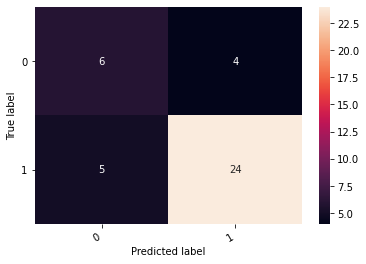

In [679]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_2.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [680]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_2.y_pred))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.86      0.83      0.84        29

    accuracy                           0.77        39
   macro avg       0.70      0.71      0.71        39
weighted avg       0.78      0.77      0.77        39



# Model 2 Decision Tree balanced Data

In [681]:
t1 = time()
dt_model_bal = DecisionTreeClassifier(class_weight = 'balanced',min_samples_leaf=40,\
                                    min_weight_fraction_leaf=0.01).fit(X_train, y_train)
t2 = time()
print(f"DecisionTree balanced took {t2-t1:.2f} seconds")

DecisionTree balanced took 0.00 seconds


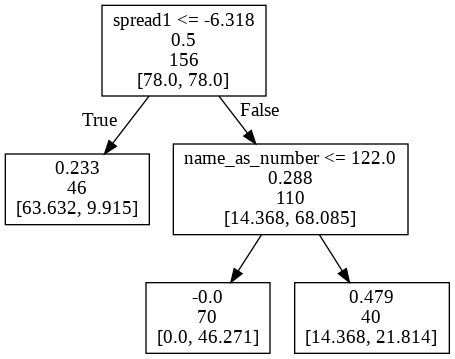

In [682]:
visualize_tree(dt_model_bal, md=5, width=600)

In [683]:
pd.Series(dt_model_bal.feature_importances_,\
          index=X_train.columns).sort_values(ascending=False)

spread1             0.85284
name_as_number      0.14716
Shimmer:APQ3        0.00000
MDVP:Fhi(Hz)        0.00000
MDVP:Flo(Hz)        0.00000
MDVP:Jitter(%)      0.00000
MDVP:Jitter(Abs)    0.00000
MDVP:RAP            0.00000
MDVP:PPQ            0.00000
Jitter:DDP          0.00000
MDVP:Shimmer        0.00000
MDVP:Shimmer(dB)    0.00000
Shimmer:APQ5        0.00000
PPE                 0.00000
MDVP:APQ            0.00000
Shimmer:DDA         0.00000
NHR                 0.00000
HNR                 0.00000
RPDE                0.00000
DFA                 0.00000
spread2             0.00000
D2                  0.00000
MDVP:Fo(Hz)         0.00000
dtype: float64

### Evaluate the model

In [684]:
X_test_pred_bal = X_test.copy()

X_test_pred_bal['y_pred'] = dt_model_bal.predict(X_test)
X_test_pred_bal['y_train'] = y_test
X_test_pred_bal.sample(6)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,y_pred,y_train
24,163.656,200.841,76.779,0.00742,0.00005,0.00380,0.00390,0.01140,0.01659,0.164,0.00738,0.00948,0.01497,0.02214,0.01778,23.831,0.397937,0.732479,-5.557447,0.220890,2.692176,0.215961,24.0,1,1
111,208.519,220.315,199.020,0.00609,0.00003,0.00368,0.00339,0.01105,0.01761,0.155,0.00952,0.01058,0.01307,0.02855,0.00830,22.407,0.338097,0.712466,-6.471427,0.184378,2.502336,0.136390,111.0,0,1
135,110.453,127.611,105.554,0.00494,0.00004,0.00244,0.00315,0.00731,0.04128,0.379,0.02229,0.02592,0.03316,0.06688,0.02529,17.707,0.653427,0.706687,-5.333619,0.322044,2.631793,0.228319,135.0,1,1
168,197.569,217.627,90.794,0.00803,0.00004,0.00490,0.00448,0.01470,0.02177,0.189,0.01279,0.01272,0.01439,0.03836,0.01337,19.269,0.372222,0.725216,-5.736781,0.164529,2.882450,0.202879,168.0,1,0
158,126.144,154.284,97.543,0.00975,0.00008,0.00593,0.00454,0.01778,0.02852,0.266,0.01500,0.01581,0.02157,0.04499,0.03828,21.534,0.635015,0.627337,-5.070096,0.280091,2.892300,0.249703,158.0,1,1
116,158.219,442.557,71.948,0.00476,0.00003,0.00214,0.00207,0.00642,0.01458,0.148,0.00606,0.00747,0.01312,0.01818,0.01554,26.356,0.450798,0.653823,-6.051233,0.273280,2.640798,0.170106,116.0,1,1


In [685]:
preds_2_bal= dt_model_bal.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_2_bal)

0.7965517241379311

Text(0.5, 15.0, 'Predicted label')

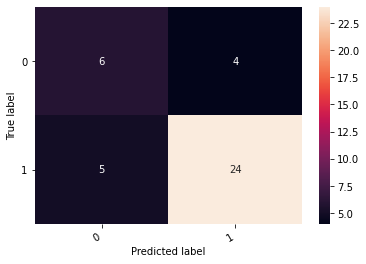

In [686]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_bal.y_pred)
DT2_model_cm = pd.DataFrame(cm, index= dt_model_bal.classes_, columns=dt_model_bal.classes_)
hmap = sns.heatmap(DT2_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [687]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_bal.y_pred))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.86      0.83      0.84        29

    accuracy                           0.77        39
   macro avg       0.70      0.71      0.71        39
weighted avg       0.78      0.77      0.77        39



In [688]:
-cross_val_score(dt_model_bal, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.5315939 , 0.67520422, 0.44880301, 0.67819815, 0.31249795,
       0.45756732, 3.08413216, 0.57288376, 0.67520422, 1.22038108,
       0.73590194, 3.0047982 , 1.11544969, 0.52605795, 0.47821439,
       0.44040382, 0.57747278, 0.42264618, 3.05147605, 0.5968513 ,
       1.29695464, 0.70269207, 0.70851353, 0.34240268, 0.60167861,
       1.26694398])

In [689]:
dt_model_bal.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.01,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [690]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [691]:
dt_model_bal_gs = GridSearchCV(estimator=dt_model_bal,\
                           param_grid=my_param_grid, cv=my_cv, scoring='neg_log_loss')

In [692]:
dt_model_bal_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                    

In [693]:
print("Best parameters:", dt_model_bal_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 60, 'min_weight_fraction_leaf': 0.01}


In [694]:
dt_model_bal_gs_best = dt_model_bal_gs.best_estimator_

In [695]:
y_test_pred_bal = pd.DataFrame(dt_model_bal_gs_best.predict_proba(X_test),\
                              columns=dt_model_bal_gs_best.classes_)

In [696]:
log_loss(y_true=y_test, y_pred=y_test_pred_bal)

0.6370418292278828

## XGBoost

In [697]:
numSplits_XGB = 4
paramGrid_XGB = {'learning_rate': [ 0.15, 0.2, 0.25], \
             'n_estimators': [10, 50, 100], 'max_depth': [5,10,15]}

In [698]:
gsModel_XGB = GridSearchCV(estimator = xgb.XGBClassifier(scale_pos_weight=(48/147),\
      verbosity = 0, random_state = randState), param_grid = paramGrid_XGB, \
    scoring = 'precision', cv = numSplits_XGB) 

t1 = time()
gsModel_XGB.fit(X_train, y_train)
t2 = time()
print(f"XGBoost took {t2-t1:.2f} seconds")

XGBoost took 2.02 seconds


In [699]:
print("{:3} classifier:\n \
    \ttrain accuracy: {:.2f}\n \
    \ttest accuracy: {:.2f}"\
    .format('DT Gradient Boosting (XGBoost)', 
            accuracy_score(gsModel_XGB.predict(X_train), y_train), 
            accuracy_score(gsModel_XGB.predict(X_test), y_test)))

DT Gradient Boosting (XGBoost) classifier:
     	train accuracy: 1.00
     	test accuracy: 0.97


In [700]:
X_test_pred_XGB = X_test.copy()

X_test_pred_XGB['y_pred'] = gsModel_XGB.predict(X_test)
X_test_pred_XGB['y_train'] = y_test
X_test_pred_XGB.sample(6)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,y_pred,y_train
173,113.715,116.443,96.913,0.00349,0.00003,0.00171,0.00203,0.00514,0.01472,0.133,0.00748,0.00905,0.01148,0.02245,0.00478,26.547,0.380253,0.766700,-5.943501,0.192150,1.852542,0.179677,173.0,0,0
145,223.361,263.872,87.638,0.00352,0.00002,0.00169,0.00188,0.00506,0.02536,0.225,0.01379,0.01478,0.01909,0.04137,0.01493,20.366,0.566849,0.574282,-5.456811,0.345238,2.840556,0.232861,145.0,1,1
122,138.190,203.522,83.340,0.00704,0.00005,0.00406,0.00398,0.01218,0.04479,0.441,0.02587,0.02567,0.03220,0.07761,0.01968,18.305,0.538016,0.741480,-5.418787,0.160267,2.090438,0.229892,122.0,1,1
86,178.222,202.450,141.047,0.00321,0.00002,0.00163,0.00194,0.00488,0.03759,0.327,0.02073,0.02415,0.02784,0.06219,0.03151,15.924,0.598714,0.712199,-6.366916,0.335753,2.654271,0.144614,86.0,1,1
165,236.200,244.663,102.137,0.00277,0.00001,0.00154,0.00153,0.00462,0.02448,0.217,0.01410,0.01426,0.01621,0.04231,0.00620,24.078,0.469928,0.628232,-6.816086,0.172270,2.235197,0.119652,165.0,0,0
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050,190.0,0,0


In [701]:
preds_XGB= gsModel_XGB.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_XGB)

1.0

Text(0.5, 15.0, 'Predicted label')

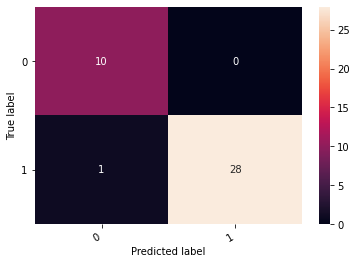

In [702]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_XGB.y_pred)
XGB_cm = pd.DataFrame(cm, index=gsModel_XGB.classes_, columns=gsModel_XGB.classes_)
hmap = sns.heatmap(XGB_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [703]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_XGB.y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.97      0.98        29

    accuracy                           0.97        39
   macro avg       0.95      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39



In [704]:
gsModel_XGB.best_params_

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 50}

# Model 3 Random Forest

In [705]:
rf_model_1 = RandomForestClassifier(class_weight = 'balanced')

rf_model_1.fit(X_train,y_train)
preds= rf_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds)

0.9517241379310345

In [706]:
pd.Series(rf_model_1.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

spread1             0.119579
PPE                 0.103208
MDVP:Fo(Hz)         0.082768
name_as_number      0.073627
Shimmer:APQ5        0.063918
MDVP:APQ            0.062771
MDVP:Shimmer        0.061472
MDVP:PPQ            0.045108
spread2             0.041120
Shimmer:APQ3        0.038069
D2                  0.035362
MDVP:RAP            0.035229
Jitter:DDP          0.033463
Shimmer:DDA         0.029668
MDVP:Fhi(Hz)        0.026127
MDVP:Jitter(Abs)    0.024286
MDVP:Flo(Hz)        0.022395
NHR                 0.021844
MDVP:Jitter(%)      0.019338
DFA                 0.019079
MDVP:Shimmer(dB)    0.017244
HNR                 0.014862
RPDE                0.009464
dtype: float64

In [707]:
y_train_pred = pd.DataFrame(rf_model_1.predict_proba(X_train), 
                            columns=rf_model_1.classes_)
y_train_pred.head()

,0,1
0,0.01,0.99
1,0.00,1.00
2,0.00,1.00
3,0.00,1.00
4,0.92,0.08


### Evaluate the model

In [708]:
X_test_pred_rf = X_test.copy()

X_test_pred_rf['y_pred'] = rf_model_1.predict(X_test)
X_test_pred_rf['y_train'] = y_test
X_test_pred_rf.sample(6)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,y_pred,y_train
126,138.145,197.238,81.114,0.00544,0.00004,0.00294,0.00327,0.00883,0.02791,0.246,0.01484,0.01805,0.02259,0.04451,0.01794,18.178,0.623209,0.738245,-5.540351,0.087165,1.821297,0.214075,126.0,1,1
135,110.453,127.611,105.554,0.00494,0.00004,0.00244,0.00315,0.00731,0.04128,0.379,0.02229,0.02592,0.03316,0.06688,0.02529,17.707,0.653427,0.706687,-5.333619,0.322044,2.631793,0.228319,135.0,1,1
24,163.656,200.841,76.779,0.00742,0.00005,0.00380,0.00390,0.01140,0.01659,0.164,0.00738,0.00948,0.01497,0.02214,0.01778,23.831,0.397937,0.732479,-5.557447,0.220890,2.692176,0.215961,24.0,1,1
107,151.884,157.765,133.751,0.00258,0.00002,0.00115,0.00122,0.00346,0.01450,0.137,0.00633,0.00788,0.01267,0.01898,0.00659,26.833,0.393563,0.700246,-6.600023,0.249172,2.499148,0.105306,107.0,1,1
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306,193.0,0,0
113,210.141,232.706,185.258,0.00534,0.00003,0.00321,0.00280,0.00964,0.01680,0.149,0.00861,0.01017,0.01301,0.02583,0.00620,23.671,0.441097,0.722254,-5.963040,0.250283,2.489191,0.177807,113.0,1,1


Text(0.5, 15.0, 'Predicted label')

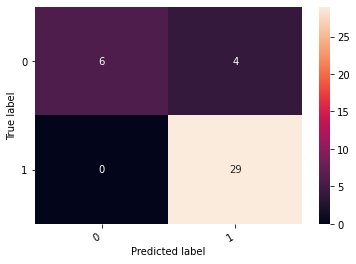

In [709]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_rf.y_pred)
RF_cm = pd.DataFrame(cm, index=rf_model_1.classes_, columns=rf_model_1.classes_)
hmap = sns.heatmap(RF_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [710]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_rf.y_pred))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.88      1.00      0.94        29

    accuracy                           0.90        39
   macro avg       0.94      0.80      0.84        39
weighted avg       0.91      0.90      0.89        39



In [711]:
dt_model_bal_gs.best_params_

{'criterion': 'gini',
 'min_impurity_decrease': 1e-05,
 'min_samples_leaf': 60,
 'min_weight_fraction_leaf': 0.01}

In [712]:
rf_model_2 = RandomForestClassifier(**dt_model_bal_gs.best_params_)

In [713]:
my_param_grid = {'bootstrap': [True, False], 
                 'n_estimators': [25, 50], 
                 'oob_score': [True, False], 
                 'warm_start': [True, False]}

In [714]:
rf_model_gs = GridSearchCV(estimator=rf_model_2, param_grid=my_param_grid,\
                           scoring='accuracy', cv=my_cv)

In [715]:
t1 = time()
rf_model_gs.fit(X_train, y_train)
t2 = time()
print(f"It took {t2 - t1:.2f} seconds")

It took 18.51 seconds


In [716]:
print(rf_model_gs.score(X_train, y_train))
print(rf_model_gs.score(X_test, y_test))

0.7564102564102564
0.7435897435897436


In [717]:
bestModel = rf_model_gs.best_estimator_
bestModel.score(X_test, y_test)

0.7435897435897436

# Model 4 Logistic Regression

In [718]:
lr_model = LogisticRegression(class_weight='balanced', random_state = randState)
lr_model.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 990,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [719]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=990, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [720]:
X_test_pred_3 = X_test.copy()

X_test_pred_3['y_pred'] = lr_model.predict(X_test)
X_test_pred_3['y_train'] = y_test
X_test_pred_3.sample(6)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,y_pred,y_train
168,197.569,217.627,90.794,0.00803,0.00004,0.00490,0.00448,0.01470,0.02177,0.189,0.01279,0.01272,0.01439,0.03836,0.01337,19.269,0.372222,0.725216,-5.736781,0.164529,2.882450,0.202879,168.0,1,0
31,199.228,209.512,192.091,0.00241,0.00001,0.00134,0.00138,0.00402,0.01015,0.089,0.00504,0.00641,0.00762,0.01513,0.00167,30.940,0.432439,0.742055,-7.682587,0.173319,2.103106,0.068501,31.0,0,0
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050,190.0,0,0
24,163.656,200.841,76.779,0.00742,0.00005,0.00380,0.00390,0.01140,0.01659,0.164,0.00738,0.00948,0.01497,0.02214,0.01778,23.831,0.397937,0.732479,-5.557447,0.220890,2.692176,0.215961,24.0,1,1
155,117.870,127.349,95.654,0.00647,0.00005,0.00356,0.00300,0.01067,0.03087,0.276,0.01659,0.01804,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256,155.0,1,1
158,126.144,154.284,97.543,0.00975,0.00008,0.00593,0.00454,0.01778,0.02852,0.266,0.01500,0.01581,0.02157,0.04499,0.03828,21.534,0.635015,0.627337,-5.070096,0.280091,2.892300,0.249703,158.0,1,1


### Evaluate the model

Text(0.5, 15.0, 'Predicted label')

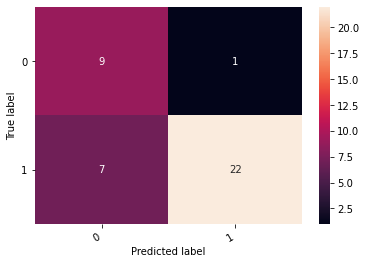

In [721]:
cm = confusion_matrix(y_true = y_test, y_pred=X_test_pred_3.y_pred)
LR_cm = pd.DataFrame(cm, index=lr_model.classes_, columns=lr_model.classes_)
hmap = sns.heatmap(LR_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [722]:
accuracy_score(y_true=y_test, y_pred=X_test_pred_3.y_pred)

0.7948717948717948

In [723]:
penalty = ['l1', 'l2']
C = np.logspace(0, 5, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [724]:
clr = GridSearchCV(lr_model, hyperparameters, cv=20, verbose=2, scoring='accuracy')

In [725]:
best_model_clr = clr.fit(X_train, y_train)
print('Best Penalty:', best_model_clr.best_estimator_.get_params()['penalty'])
print('Best C:', round(best_model_clr.best_estimator_.get_params()['C'],2))

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    6.8s finished


In [726]:
y_pred_gs = best_model_clr.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [727]:
pd.DataFrame(cm_gs, index=best_model_clr.classes_, columns=best_model_clr.classes_)

,0,1
0,8,2
1,4,25


In [728]:
y_pred_lr = lr_model.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [729]:
print(classification_report(y_true=y_test,
                            y_pred=y_pred_gs))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.93      0.86      0.89        29

    accuracy                           0.85        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.86      0.85      0.85        39



In [730]:
accuracy_score(y_true=y_test, y_pred= y_pred_gs)

0.8461538461538461

In [731]:
Parkinsons_probs = pd.DataFrame(best_model_clr.predict_proba(X_train), \
                          columns=['P({})'.format(x) for x in best_model_clr.classes_], index=X_train.index)
X_train = X_train.join(Parkinsons_probs)
X_train.sample(10)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,name_as_number,P(0),P(1)
129,120.078,126.632,105.667,0.00270,0.00002,0.00116,0.00135,0.00349,0.01022,0.090,0.00476,0.00588,0.00903,0.01428,0.00487,26.369,0.491345,0.718839,-5.892061,0.195976,2.108873,0.183572,129.0,0.468289,0.531711
91,151.955,163.335,147.226,0.00419,0.00003,0.00224,0.00227,0.00672,0.07959,0.772,0.04421,0.04962,0.05690,0.13262,0.01658,19.664,0.501037,0.714360,-6.411497,0.207156,2.344876,0.134120,91.0,0.021948,0.978052
25,104.400,206.002,77.968,0.00633,0.00006,0.00316,0.00375,0.00948,0.03767,0.381,0.01732,0.02245,0.03780,0.05197,0.02887,22.066,0.522746,0.737948,-5.571843,0.236853,2.846369,0.219514,25.0,0.001209,0.998791
164,102.273,142.830,85.902,0.00907,0.00009,0.00493,0.00461,0.01480,0.02814,0.272,0.01579,0.01553,0.02073,0.04736,0.03882,18.447,0.671378,0.674562,-2.929379,0.396746,2.560422,0.367233,164.0,0.000087,0.999913
171,112.547,133.374,105.715,0.00355,0.00003,0.00166,0.00190,0.00499,0.01358,0.129,0.00664,0.00786,0.01140,0.01992,0.00435,26.436,0.413295,0.756700,-6.323531,0.218885,2.193412,0.160376,171.0,0.766856,0.233144
7,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,0.00829,0.00946,0.01256,0.02487,0.00344,26.892,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755,7.0,0.118614,0.881386
157,117.963,134.209,100.757,0.01813,0.00015,0.01117,0.00718,0.03351,0.04912,0.438,0.02610,0.02161,0.02916,0.07830,0.10748,19.075,0.630547,0.646786,-3.444478,0.303214,2.964568,0.261305,157.0,0.000033,0.999967
112,204.664,221.300,189.621,0.00841,0.00004,0.00502,0.00485,0.01506,0.02378,0.210,0.01277,0.01483,0.01767,0.03831,0.01316,21.305,0.498877,0.722085,-4.876336,0.212054,2.376749,0.268144,112.0,0.034147,0.965853
115,151.872,492.892,69.085,0.00856,0.00006,0.00404,0.00385,0.01211,0.01843,0.235,0.00796,0.00832,0.01271,0.02389,0.06051,23.693,0.407701,0.662668,-4.673241,0.261549,2.702355,0.274407,115.0,0.008969,0.991031
6,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,0.00779,0.00937,0.01351,0.02337,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,6.0,0.079701,0.920299
